In [3]:
!git clone https://github.com/muxspace/facial_expressions.git

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 25.25 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Checking out files: 100% (13996/13996), done.


In [4]:
import pandas as pd
data=pd.read_csv('/content/facial_expressions/data/legend.csv')
df=data.copy()
dic={}
df.isnull().sum()
data.head()

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral


In [5]:

df.iloc[0,2]

'anger'

example for anger

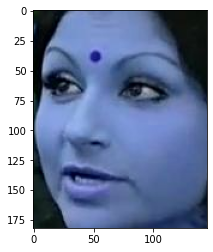

In [49]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/master_data/testing/anger/SharmilaTagore_45.jpg')
plt.imshow(img)

In [6]:
for i in range(len(df.emotion)):
  key=df.iloc[i,2].lower()
  if key in dic:
    dic[key].append(df.iloc[i,1])
  else:
    dic[key]=[df.iloc[i,1]]


In [7]:
emotion_list=list(dic.keys())
print(emotion_list)

['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness', 'sadness', 'contempt']


In [8]:
import os
os.mkdir('master_data')
os.mkdir('master_data/training')
os.mkdir('master_data/testing')

In [9]:
for emotion in emotion_list:

  os.mkdir(os.path.join('master_data/training',emotion))
  os.mkdir(os.path.join('master_data/testing',emotion))


In [10]:
from shutil import copyfile
split_size=0.7
for emotion,images in dic.items():
  train_size=int(split_size*len(images))
  train_images=images[:train_size]
  test_images=images[train_size:]
  for image in train_images:
   source=os.path.join('/content/facial_expressions/images',image)
   des=os.path.join('/content/master_data/training',emotion,image)
   copyfile(source,des)

  for image in test_images:
   source=os.path.join('/content/facial_expressions/images',image)
   des=os.path.join('/content/master_data/testing',emotion,image)
   copyfile(source,des)


MODEL BUILDING


In [22]:
from tensorflow.python.framework.func_graph import flatten
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Convolution2D,MaxPool2D,Dense,Flatten
model=tf.keras.models.Sequential ([
    
    Conv2D(16,(3,3),activation='relu',input_shape=(100,100,3)),
    MaxPool2D(2,2),
    Flatten(),
    Dense(1024,activation='relu'),

    Dense(8,activation='Softmax')

])
model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 38416)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              39339008  
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_8 (Dense)             (None, 8)                 8200      
                                                      

Image Data Generator 

In [23]:
train_dir='/content/master_data/training'
test_dir='/content/master_data/testing'
train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(100,100),
    class_mode='categorical',
    batch_size=128
)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    class_mode='categorical',
    batch_size=128
)
es=EarlyStopping(monitor='val_accuracy',patience=2,min_delta=0.01)

Found 9572 images belonging to 8 classes.
Found 4111 images belonging to 8 classes.


In [24]:
model.fit_generator(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    callbacks=[es]
)

Epoch 1/10


<ipython-input-24-c75d829bc7ea>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


75/75 [==============================] - 17s 222ms/step - loss: 8.8243 - accuracy: 0.4757 - val_loss: 1.0448 - val_accuracy: 0.5013
Epoch 2/10
75/75 [==============================] - 16s 218ms/step - loss: 1.0432 - accuracy: 0.4911 - val_loss: 1.0483 - val_accuracy: 0.5013
Epoch 3/10
75/75 [==============================] - 16s 217ms/step - loss: 1.0428 - accuracy: 0.4880 - val_loss: 1.0435 - val_accuracy: 0.5013


In [18]:
scoreSeg = model.evaluate_generator(test_generator)
print(scoreSeg)

<ipython-input-18-5d7dfe9b4ffe>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoreSeg = model.evaluate_generator(test_generator)


[1.041165828704834, 0.5010946393013]
